Estimated Gaussian noise standard deviation = 0.14979346660543966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008292126048275662..0.8468687916401824].


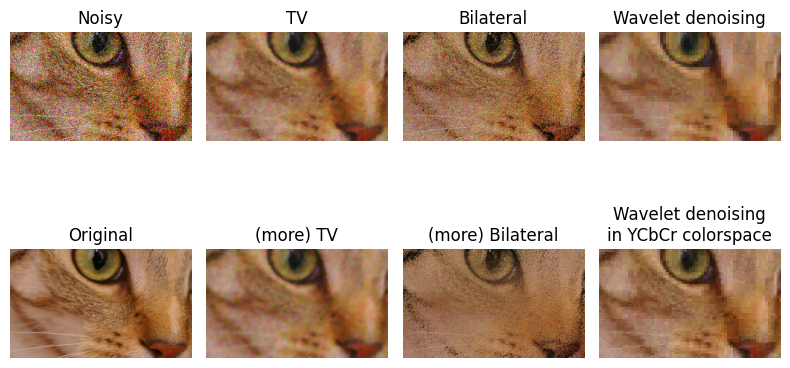

In [1]:
import matplotlib.pyplot as plt

from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma,
)
from skimage import data, img_as_float
from skimage.util import random_noise


original = img_as_float(data.chelsea()[100:250, 50:300])

sigma = 0.155
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5), sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, channel_axis=-1))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(
    denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15, channel_axis=-1)
)
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, channel_axis=-1, rescale_sigma=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, channel_axis=-1))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(
    denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15, channel_axis=-1)
)
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(
    denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True, rescale_sigma=True)
)
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

In [9]:
import cv2

cap = cv2.VideoCapture('sample.mp4')

if not cap.isOpened():
    print("❌ Error: Cannot open video file.")
else:
    print("✅ Video loaded successfully!")

    ret, frame = cap.read()
    if ret:
        print(f"✅ First frame shape: {frame.shape}")
    else:
        print("❌ Couldn't read the first frame.")
cap.release()


✅ Video loaded successfully!
✅ First frame shape: (4096, 2160, 3)


In [10]:
import cv2
import numpy as np
import os

video_path = 'sample.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("❌ Error: Cannot open video file.")
    exit()

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# VideoWriters for processed videos
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_thresh = cv2.VideoWriter('video_thresh.mp4', fourcc, fps, (frame_width, frame_height), isColor=False)
out_smooth = cv2.VideoWriter('video_smooth.mp4', fourcc, fps, (frame_width, frame_height))
out_canny = cv2.VideoWriter('video_canny.mp4', fourcc, fps, (frame_width, frame_height), isColor=False)
out_bitwise = cv2.VideoWriter('video_bitwise_not.mp4', fourcc, fps, (frame_width, frame_height))

# Save extracted frames
if not os.path.exists('frames'):
    os.makedirs('frames')

frame_list = []
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Save original frame
    frame_list.append(frame)
    cv2.imwrite(f'frames/frame_{frame_count:04d}.jpg', frame)

    # --- Processing ---
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1. Adaptive Threshold
    thresh = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    out_thresh.write(thresh)

    # 2. Gaussian Smoothing
    blur = cv2.GaussianBlur(frame, (11, 11), 0)
    out_smooth.write(blur)

    # 3. Canny Edge
    canny = cv2.Canny(gray, 50, 150)
    out_canny.write(canny)

    # 4. Bitwise NOT
    bitwise = cv2.bitwise_not(frame)
    out_bitwise.write(bitwise)

    frame_count += 1

print(f"✅ Processed {frame_count} frames")

cap.release()
out_thresh.release()
out_smooth.release()
out_canny.release()
out_bitwise.release()

# ✅ Create a collage
def create_collage(frames, cols=5, collage_name='collage.jpg'):
    if len(frames) == 0:
        print("❌ No frames to create collage")
        return

    n = len(frames)
    rows = (n + cols - 1) // cols
    h, w, _ = frames[0].shape
    collage = np.zeros((rows * h, cols * w, 3), dtype=np.uint8)

    for idx, img in enumerate(frames):
        r = idx // cols
        c = idx % cols
        collage[r*h:(r+1)*h, c*w:(c+1)*w, :] = img

    cv2.imwrite(collage_name, collage)
    print(f"✅ Collage saved as {collage_name}")

# Collage from first 20 frames (or all if < 20)
create_collage(frame_list[:20])


✅ Processed 481 frames
✅ Collage saved as collage.jpg
